In [1]:
import pandas as pd
import numpy as np
from numpy.linalg import svd, det, norm
import matplotlib.pyplot as plt

# Distance Geometry

Below we import  the `cRMSD` function and the auxiliary functions `translate`, `rotate` that are further explained in the `cRMSD_dRMSD.ipynb` jupyter notebook. 

In [2]:
def translate(x):
    x_c = np.mean(x, axis=0)
    X = []
    for item in x:
        X.append(np.subtract(item,x_c))
    X = np.array(X) 
    return X

def rotate(X, Y):
    
    # SVD calculation of U, Σ, V
    U, S, V = svd(X.T @ Y)
    
    # Calculate Q
    Q = U @ V
    
    # Check det
    if det(Q) < 0:
        for i in range(3):
            U[i][2] = U[i][2] * (-1)
        Q = U @ V
        
    return Q

def cRMSD(x, y):
    
    # Translate to common origin
    X = translate(x)
    Y = translate(y)
    
    N = len(X)
    
    # Rotate to optimal alignment
    Q = rotate(X, Y)
    
    # Calculate RMSD
    #RMSD = norm(X @ Q - Y) / np.sqrt(len(x)) # vectorized solution
    sigma = 0
    for i in range(N):
        sigma += norm(X[i] @ Q - Y[i])**2

    cRMSD = np.sqrt(1 / N * sigma)   
    
    return cRMSD

We obtain the coordinates of the 50 $C_{\alpha}$ atoms of SARS-COV-2 Spike glycoprotein (PDB id: 7NEH), indexed E401 to E450, using the `MDAnalysis` python library used in PART I and save them in the `coordinates.csv` file.

The `coordinates.csv` file is provided to you, in case you don't want to install the `MDAnalysis` library. You can either use the coordinates directly by commenting out and running the following cell,

In [3]:
# coordinates = E_original.select_atoms('resid 401:450 and name CA').positions # obtain the coordinates
# np.savetxt("coordinates.csv", coordinates, delimiter = ",") # save them in a file

or you can load the `coordinates.csv` file and obtain the coordinates this way: 

In [4]:
with open('../data/coordinates.csv', 'r') as file:
    coors = []
    for line in file:
        if len(line.strip().split(',')) == 3 :
            coor = np.zeros(3) 
            for i,value in enumerate(line.strip().split(',')):
                coor[i] = float(value)
            coors.append(coor)

In [5]:
# coors # Uncomment to see the obtained coordinates

# Calculate Cayley-Menger Matrix B

The `compute_distance_matrix` function computes the distances between the coordinates. Since the matrix is symmetric, we only compute the coordinates for the lower triangular matrix for efficiency.

In [6]:
def compute_distance_matrix(x):
    matrix_M = np.zeros((len(x),len(x)))
    for i in range(len(x)):
        for j in range(0,i):
            matrix_M[i][j] = ((norm(x[i]-x[j]))**2)/2
            matrix_M[j][i] = matrix_M[i][j]
    return matrix_M       

In [7]:
M = compute_distance_matrix(coors)
dfm = pd.DataFrame(M)
dfm.head()

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,0.000000,7.282306,25.376080,44.483113,70.144568,49.279283,44.994719,86.352430,79.651803,63.522896,...,61.646127,37.152730,61.577198,103.666161,157.632898,170.193599,110.993598,73.268865,74.757190,55.470116
1,7.282306,0.000000,7.248474,22.270880,34.951604,20.484108,24.520965,54.830459,49.600620,46.971020,...,86.314676,53.566223,68.723920,115.227273,162.735736,166.873418,108.490459,80.599640,79.317459,71.344140
2,25.376080,7.248474,0.000000,7.133697,14.444006,13.443128,22.987026,48.628424,52.746079,61.623506,...,92.013970,59.435034,62.378229,107.516743,143.580813,145.720733,96.387351,81.849084,86.995907,92.007862
3,44.483113,22.270880,7.133697,0.000000,7.226499,14.650858,16.402407,35.328874,52.149929,61.791367,...,101.761971,77.493748,80.175042,132.613676,168.497703,179.412771,131.021250,119.319590,135.150508,141.944119
4,70.144568,34.951604,14.444006,7.226499,0.000000,7.302698,17.250713,24.158980,36.569274,57.405421,...,159.708388,123.662949,121.429434,180.596571,214.943007,215.229160,162.106900,155.284477,162.797761,176.784336


The `computer_boarder_matrix` computes the distances between the coordinates and adds unit padding to the resulted matrix. Similar to `compute_distance_matrix`, since the distance matrix is symmetric, it only computes half of the distances for efficiency.

In [8]:
def compute_boarder_matrix(x):
    # Initialization
    matrix_dim = len(x) + 1 # defining matrix dimensions
    matrix_B = np.ones((matrix_dim,matrix_dim)) # initializing the matrix with ones
    
    # Filling the matrxi with the distances and maintaing the ones in the first row and first column
    for i in range(matrix_dim):
        for j in range(0,i+1):
            if i==j:
                matrix_B[i][j] = 0.
            elif (i>0) and (j>0):
                matrix_B[i][j] = ((norm(x[i-1]-x[j-1]))**2)/2
                matrix_B[j][i] = matrix_B[i][j]
    return matrix_B

In [9]:
B = compute_boarder_matrix(coors)
dfb = pd.DataFrame(B)
dfb.head()

,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,50
0,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.0,0.000000,7.282306,25.376080,44.483113,70.144568,49.279283,44.994719,86.352430,79.651803,...,61.646127,37.152730,61.577198,103.666161,157.632898,170.193599,110.993598,73.268865,74.757190,55.470116
2,1.0,7.282306,0.000000,7.248474,22.270880,34.951604,20.484108,24.520965,54.830459,49.600620,...,86.314676,53.566223,68.723920,115.227273,162.735736,166.873418,108.490459,80.599640,79.317459,71.344140
3,1.0,25.376080,7.248474,0.000000,7.133697,14.444006,13.443128,22.987026,48.628424,52.746079,...,92.013970,59.435034,62.378229,107.516743,143.580813,145.720733,96.387351,81.849084,86.995907,92.007862
4,1.0,44.483113,22.270880,7.133697,0.000000,7.226499,14.650858,16.402407,35.328874,52.149929,...,101.761971,77.493748,80.175042,132.613676,168.497703,179.412771,131.021250,119.319590,135.150508,141.944119


# Compute rank(B)

Then we compute the rank of the padded matrix $\mathbf{B}$.

As expected, the rank of the matrix is $5$ since from the Cayley-Menger theorem it should be $rank(\mathbf{M})+2$, where the rank of $\mathbf{M}$ is $3$ because it represents the distances of the embedded coordinates in $3$ dimensions.

In [10]:
rank_b = np.linalg.matrix_rank(B)
rank_b

5

# Perturb entries by 2% and 4%

Next, we perturb the entries of the matrix $\mathbf{B}$ by $2\%$ and $4\%$. To that end, we created the function `perturb`, that perturbs the entries of a matrix by a given percentage. The functions selects, uniformly at random, a perturb value, according to the given percentage, that adds to the original one in order to obtain the resulted perturbed matrix.

In [11]:
def perturb(matrix, p):
    
    matrix_dim = len(matrix[0])
    perturbed_matrix = np.zeros((matrix_dim, matrix_dim))
    
    for i in range(1,matrix_dim):
        for j in range(1,i):
            old_value = matrix[i][j] # old value of i,j cell in the matrix
            per_value = p / 100 * old_value # maximum number to add, accoriding to "p" 
            random_value = np.random.choice([-per_value, +per_value]) # calculate the random value that will be added to the orgianl value
            new_value = np.abs(old_value + random_value) # add the new value

            
            perturbed_matrix[i][j] = new_value # attribute the perturbed value to the matrix
            perturbed_matrix[j][i] = perturbed_matrix[i][j]
    
    return perturbed_matrix

In [12]:
# Perturb entries by 2%
per2 = perturb(B,2)
dfper2 = pd.DataFrame(per2)


# Perturb entr1ies by 4%
per4 = perturb(B,4)
dfper4 = pd.DataFrame(per4)

# Rank of perturbed matrices

Then, we compute the rank of each perturbed matrix. As expected the rank of the perturbed matrices is larger than $5$ since the perturbation makes the matrix unable to be embedded in $3$ dimensions.

In [13]:
rank_per2 = np.linalg.matrix_rank(per2)
rank_per4 = np.linalg.matrix_rank(per4)

print(rank_per2, rank_per4)

50 50


# Compute Coordinates

In order to obtain the $3$-dimensional coordinates, we have to compute the Gram matrix and the perform SVD on the Gram matrix. From the resulted matrix $\Sigma$ we can create a new matrix $\Sigma'$.

In [14]:
def compute_3D_coordinates(matrix_B):
    
    # Initialize the Gram matrix
    matrix_dimensions = len(matrix_B) -1
    matrix_G = np.zeros((matrix_dimensions, matrix_dimensions))
    
    # Compute the Gram matrix, using the border Cayley Menger entries and
    # using as origin the coordinates of the first structure.
    for i in range(1, matrix_dimensions):
        for j in range(1, matrix_dimensions):
            matrix_G[i-1][j-1] = matrix_B[i, 1] - matrix_B[i, j] + matrix_B[1, j]
            
    # Apply SVD to Gram matrix       
    U, S, V_T = svd(matrix_G)
    
    # Generate a diagonal matrix S' that holds only the first three entries of S
    # in its diagonal and all the other entries are 0.
    S[3:] = 0
    S_prime = np.diag(S)
    
    # Compoute the coordinates P = S'^(1/2)*V^T
    P = np.sqrt(S_prime) @ V_T
    coordinates = P[0:3, :].T
    
    return coordinates

In [15]:
coors_per2 = compute_3D_coordinates(per2)

In [16]:
cRMSD(coors,coors_per2)

1.5117783845218153

In [17]:
coors_per4 = compute_3D_coordinates(per4)

In [18]:
cRMSD(coors,coors_per4)

1.6575069796260629

In [19]:
noise_perturbation = [2, 4, 6, 10, 15, 20, 25, 30, 40, 50]
cRMSD_perturbed = []

for noise in noise_perturbation:
    pertubed_matrix = perturb(B,noise)
    approximate_coors = compute_3D_coordinates(pertubed_matrix)
    cRMSD_perturbed.append(cRMSD(coors, approximate_coors))

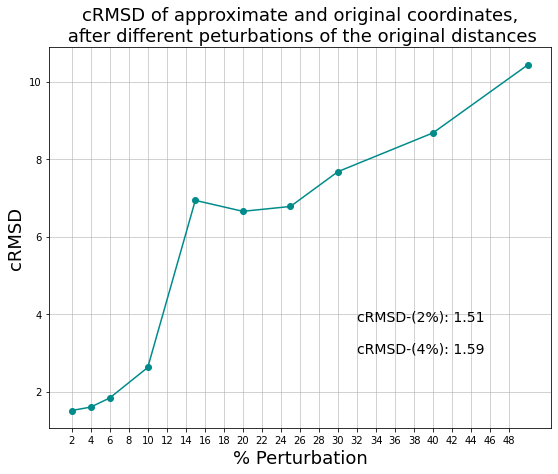

In [20]:
plt.figure(figsize=(9,7))
plt.plot(noise_perturbation,cRMSD_perturbed, color='darkcyan', marker='o')
plt.grid(alpha=0.7)
plt.xticks([i for i in range(2,50,2)])
plt.xlabel('% Perturbation', fontsize=18)
plt.ylabel('cRMSD', fontsize=18)
plt.title('cRMSD of approximate and original coordinates,\n after different peturbations of the original distances', 
         fontsize=18)
plt.text(32, 3, 'cRMSD-(2%): ' + str(cRMSD_perturbed[0])[:4] + '\n\n' +
                'cRMSD-(4%): ' + str(cRMSD_perturbed[1])[:4], fontsize=14)
plt.savefig('cRMSD_for different_perturbations.pdf')
plt.show()

As shown in the figure above, the more we perturb the original matrix, the more the c-RMSD increase.